In [1]:
#%%capture
!pip install yfinance==0.2.58
#!pip install yfinance
#!pip install twelvedata
import numpy as np
import pandas as pd
import yfinance as yf
!pip show yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.64
    Uninstalling yfinance-0.2.64:
      Successfully uninstalled yfinance-0.2.64
Name: yfinance
Version: 0.2.58
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


In [49]:
ticker = "1050.SR"
data = yf.download(ticker, start="2022-01-01", end="2025-06-23")
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR
Date,,,,,
2022-01-02,22.431108,22.477986,21.938889,22.032645,661866
2022-01-03,22.032646,22.431110,21.915452,22.431110,896120
2022-01-04,21.704500,22.220158,21.634184,22.220158,941467
2022-01-05,21.798258,21.892013,21.704501,21.892013,897159
2022-01-06,21.610744,21.798257,21.563867,21.798257,444156
...,...,...,...,...,...
2025-06-16,17.320000,17.500000,17.200001,17.360001,1715571
2025-06-17,16.920000,17.340000,16.920000,17.200001,1613717


In [50]:
# Find the lowest price for the stock over the last week
data["prv_low_1"] = data["Low"].shift(1)
data["prv_low_2"] = data["Low"].shift(2)
data["prv_low_3"] = data["Low"].shift(3)
data["prv_low_4"] = data["Low"].shift(4)
data["prv_low_5"] = data["Low"].shift(5)
data["Low_Last_5d"] = data[["prv_low_1", "prv_low_2","prv_low_3","prv_low_4","prv_low_5"]].values.min(1)
data = data.drop(["prv_low_1", "prv_low_2", "prv_low_3", "prv_low_4", "prv_low_5"], axis=1)

# Find the highest price for the stock over the last week
data['prv_high_1'] = data["High"].shift(1)
data['prv_high_2'] = data["High"].shift(2)
data['prv_high_3'] = data["High"].shift(3)
data['prv_high_4'] = data["High"].shift(4)
data['prv_high_5'] = data["High"].shift(5)
data["High_Last_5d"] = data[["prv_high_1", "prv_high_2","prv_high_3","prv_high_4","prv_high_5"]].values.max(1)
data = data.drop(["prv_high_1", "prv_high_2", "prv_high_3", "prv_high_4", "prv_high_5"], axis=1)
data.tail(2)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d
Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR,,
Date,,,,,,,
2025-06-19,16.52,16.879999,16.32,16.879999,3070535,16.60,17.66
2025-06-22,16.60,16.740000,16.40,16.520000,372026,16.32,17.50


In [51]:
# Create boolean variable marking whether stock dropped at least six percent in the last week (five days)
data["six_percent_of_close_price"] = .94*data["Close"]
data["Close"] = 1*data["Close"]
data["six_percent_of_close_price_within_last_five_days"] = np.where((data['Low_Last_5d'] <= data['six_percent_of_close_price']) & (data['six_percent_of_close_price'] <= data['High_Last_5d']), True, False)

In [52]:
# Create boolean variable marking whether current close price is greater than yesterdays close price
data["Last_Close"] = data["Close"].shift(1)
data["close_diff"] = data["Close"].values.reshape(data.shape[0]) - data["Last_Close"].values.reshape(data.shape[0])
data["up_from_yesterday"] = np.where((data["close_diff"] > 0), True, False)
data.tail(5)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d,six_percent_of_close_price,six_percent_of_close_price_within_last_five_days,Last_Close,close_diff,up_from_yesterday
Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR,,,,,,,
Date,,,,,,,,,,,,
2025-06-16,17.320000,17.500000,17.200001,17.360001,1715571,16.60,17.860001,16.280800,False,17.360001,-0.040001,False
2025-06-17,16.920000,17.340000,16.920000,17.200001,1613717,16.60,17.860001,15.904800,False,17.320000,-0.400000,False
2025-06-18,16.700001,16.980000,16.700001,16.920000,1294086,16.60,17.860001,15.698001,False,16.920000,-0.219999,False
2025-06-19,16.520000,16.879999,16.320000,16.879999,3070535,16.60,17.660000,15.528800,False,16.700001,-0.180000,False
2025-06-22,16.600000,16.740000,16.400000,16.520000,372026,16.32,17.500000,15.604000,False,16.520000,0.080000,True


In [53]:
# Buy stock if price dropped at least seven percent in last week and current close price is greater than yesterdays close price
data["shortsell"] = data["six_percent_of_close_price_within_last_five_days"] & data["up_from_yesterday"]
data["shortsellcumsum"] = data["shortsell"].cumsum().astype('int64')
data = data.drop(["Last_Close","close_diff","six_percent_of_close_price","up_from_yesterday","six_percent_of_close_price_within_last_five_days","Low_Last_5d","High_Last_5d"], axis=1)

# Add numerical columns of stocks current close price increased and decrease by one percent for final analysis
data["Close_up1%"] = 1.01*data["Close"]
data["Close_down1%"] = .99*data["Close"]
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR,,,,
Date,,,,,,,,,
2025-06-03,16.940001,17.059999,16.760000,16.879999,1633734,False,72,17.109401,16.770601
2025-06-04,17.459999,17.680000,16.959999,17.000000,4687915,False,72,17.634599,17.285399
2025-06-11,17.440001,17.860001,17.200001,17.799999,2798838,False,72,17.614401,17.265601
2025-06-12,17.459999,17.660000,17.120001,17.500000,2616960,False,72,17.634599,17.285399
2025-06-15,17.360001,17.360001,16.600000,16.600000,888499,False,72,17.533601,17.186401
2025-06-16,17.320000,17.500000,17.200001,17.360001,1715571,False,72,17.493200,17.146800
2025-06-17,16.920000,17.340000,16.920000,17.200001,1613717,False,72,17.089200,16.750800
2025-06-18,16.700001,16.980000,16.700001,16.920000,1294086,False,72,16.867001,16.533001


In [54]:
# view dates where we buy the stock + the two days after
#buyclause = data['buy']==True
#view = data[buyclause.shift(2)|buyclause.shift()|buyclause]
#view

In [55]:
data.loc[(data.shortsell == False), 'Close_up1%'] = np.nan
data.loc[(data.shortsell == False), 'Close_down1%'] = np.nan
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR,,,,
Date,,,,,,,,,
2025-06-03,16.940001,17.059999,16.760000,16.879999,1633734,False,72,NaN,NaN
2025-06-04,17.459999,17.680000,16.959999,17.000000,4687915,False,72,NaN,NaN
2025-06-11,17.440001,17.860001,17.200001,17.799999,2798838,False,72,NaN,NaN
2025-06-12,17.459999,17.660000,17.120001,17.500000,2616960,False,72,NaN,NaN
2025-06-15,17.360001,17.360001,16.600000,16.600000,888499,False,72,NaN,NaN
2025-06-16,17.320000,17.500000,17.200001,17.360001,1715571,False,72,NaN,NaN
2025-06-17,16.920000,17.340000,16.920000,17.200001,1613717,False,72,NaN,NaN
2025-06-18,16.700001,16.980000,16.700001,16.920000,1294086,False,72,NaN,NaN


In [56]:
data["Close_up1%"] = data["Close_up1%"].ffill()
data["Close_down1%"] = data["Close_down1%"].ffill()
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR,,,,
Date,,,,,,,,,
2025-06-03,16.940001,17.059999,16.760000,16.879999,1633734,False,72,18.127842,17.768875
2025-06-04,17.459999,17.680000,16.959999,17.000000,4687915,False,72,18.127842,17.768875
2025-06-11,17.440001,17.860001,17.200001,17.799999,2798838,False,72,18.127842,17.768875
2025-06-12,17.459999,17.660000,17.120001,17.500000,2616960,False,72,18.127842,17.768875
2025-06-15,17.360001,17.360001,16.600000,16.600000,888499,False,72,18.127842,17.768875
2025-06-16,17.320000,17.500000,17.200001,17.360001,1715571,False,72,18.127842,17.768875
2025-06-17,16.920000,17.340000,16.920000,17.200001,1613717,False,72,18.127842,17.768875
2025-06-18,16.700001,16.980000,16.700001,16.920000,1294086,False,72,18.127842,17.768875


In [57]:
data["buyup"] = np.where((data["Close"].values.reshape(data.shape[0])-data["Close_up1%"].values.reshape(data.shape[0]) > 0),True,False)
data["buydown"] = np.where((data["Close_down1%"].values.reshape(data.shape[0])-data["Close"].values.reshape(data.shape[0]) > 0),True,False)
data["buy"] = data["buydown"]|data["buyup"]
data["buycumsum"] = data["buy"].cumsum().astype('int64')
#data.to_csv('out.csv', index=False)
#data = pd.read_csv('out.csv')
#data.tail(10)

In [58]:
data.to_csv("out.csv")
data = pd.read_csv("out.csv")
data.head(10)

,Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
0,Ticker,1050.SR,1050.SR,1050.SR,1050.SR,1050.SR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-02,22.431108474731445,22.47798612657476,21.93888942140822,22.032644725094848,661866,False,0.0,NaN,NaN,False,False,False,0.0
3,2022-01-03,22.03264617919922,22.43110995513352,21.915452041856387,22.43110995513352,896120,False,0.0,NaN,NaN,False,False,False,0.0
4,2022-01-04,21.704500198364258,22.220158098769467,21.634183717713807,22.220158098769467,941467,False,0.0,NaN,NaN,False,False,False,0.0
5,2022-01-05,21.79825782775879,21.892013137302932,21.704500663730325,21.892013137302932,897159,False,0.0,NaN,NaN,False,False,False,0.0
6,2022-01-06,21.61074447631836,21.798256942273866,21.563866823450546,21.798256942273866,444156,False,0.0,NaN,NaN,False,False,False,0.0
7,2022-01-09,22.009206771850586,22.14984158744099,21.634183687749978,21.634183687749978,668513,False,0.0,NaN,NaN,False,False,False,0.0
8,2022-01-10,21.985767364501953,22.267036988256304,21.962328538269798,22.009206190734112,1924647,False,0.0,NaN,NaN,False,False,False,0.0
9,2022-01-11,22.26703643798828,22.26703643798828,21.98576682118473,21.98576682118473,1075981,False,0.0,NaN,NaN,False,False,False,0.0


In [59]:
entry_exit_values = []
dates = []
for x in range(1,int(data["shortsellcumsum"].max())+1):
  frame = data.loc[data.shortsellcumsum==x]
  if (frame.loc[frame.buy==True].shape[0]>=1):
    ssclose = float(frame.loc[frame.shortsell==True]["Close"].to_list()[0])
    buyclose = float(frame.loc[frame.buy==True]["Close"].to_list()[0])
    entry_exit_values.append(ssclose-buyclose)
    dates.append(frame.loc[frame.buy==True]["Price"].to_list()[0])

In [60]:
entry_exit_values

[0.7969245910644531,
 0.2812690734863281,
 0.9844379425048828,
 -0.6094150543212891,
 1.125070571899414,
 -1.6876068115234375,
 1.3829002380371094,
 0.2812671661376953,
 0.2812671661376953,
 0.5625343322753906,
 0.35158348083496094,
 0.3047065734863281,
 0.2109508514404297,
 0.30470848083496094,
 0.5859737396240234,
 0.2109508514404297,
 0.5625362396240234,
 0.2109527587890625,
 -0.21094894409179688,
 0.468780517578125,
 0.5625362396240234,
 0.3047065734863281,
 0.39846229553222656,
 0.2812671661376953,
 0.6328535079956055,
 0.6094131469726562,
 0.2109508514404297,
 0.2812671661376953,
 0.5390968322753906,
 0.6562900543212891,
 0.37502479553222656,
 0.16407299041748047,
 0.3111305236816406,
 0.5444784164428711,
 -0.21390151977539062,
 0.3111305236816406]

In [61]:
def cumlative_pnl(entry_exit_values):
  cumpnl = 0
  pnl = []
  for num in entry_exit_values:
    cumpnl += num
    pnl.append(cumpnl)
  return pnl
import datetime as dt
from datetime import datetime

pnl = cumlative_pnl(entry_exit_values=entry_exit_values)
#pnl = [diff*115 for diff in pnl]

date_objects = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [62]:
print(date_objects)
print(pnl)

[datetime.date(2022, 2, 2), datetime.date(2022, 3, 3), datetime.date(2022, 3, 21), datetime.date(2022, 3, 30), datetime.date(2022, 4, 26), datetime.date(2022, 5, 30), datetime.date(2022, 6, 19), datetime.date(2022, 6, 30), datetime.date(2022, 7, 24), datetime.date(2022, 8, 7), datetime.date(2022, 10, 6), datetime.date(2022, 10, 25), datetime.date(2022, 11, 28), datetime.date(2022, 12, 4), datetime.date(2022, 12, 20), datetime.date(2023, 1, 2), datetime.date(2023, 3, 14), datetime.date(2023, 4, 5), datetime.date(2023, 4, 17), datetime.date(2023, 6, 20), datetime.date(2023, 7, 5), datetime.date(2023, 7, 13), datetime.date(2023, 7, 19), datetime.date(2023, 10, 15), datetime.date(2023, 10, 22), datetime.date(2023, 11, 9), datetime.date(2023, 11, 22), datetime.date(2023, 12, 21), datetime.date(2024, 1, 9), datetime.date(2024, 1, 30), datetime.date(2024, 7, 29), datetime.date(2024, 12, 12), datetime.date(2025, 4, 3), datetime.date(2025, 4, 9), datetime.date(2025, 4, 21), datetime.date(2025, 

Text(0, 0.5, 'Cumulative PNL ($)')

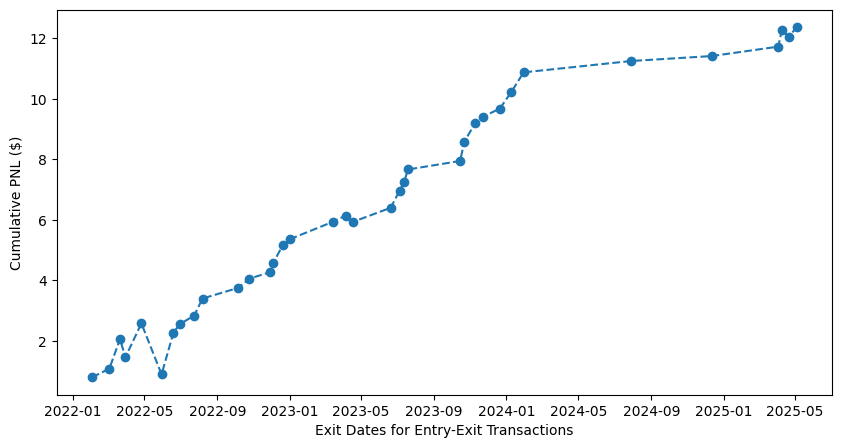

In [63]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(date_objects, pnl,marker='o', linestyle='dashed')
plt.xlabel('Exit Dates for Entry-Exit Transactions')
plt.ylabel('Cumulative PNL ($)')